## Dataset 1: Marine Microplastic Concentration

#### Importing and installing dependencies

In [3]:
import folium
from folium.plugins import HeatMap, MousePosition
from folium.plugins import MiniMap

import pandas as pd
import geopandas as gpd

from scipy.interpolate import NearestNDInterpolator

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from mpl_toolkits.basemap import Basemap
import seaborn as sns

#### Reading Datasets from the CSV files

In [3]:
plastic = pd.read_csv('./data/Marine_Microplastics_WGS84_5159774935198085819.csv')
plastic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22266 entries, 0 to 22265
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OBJECTID          22266 non-null  int64  
 1   Oceans            21995 non-null  object 
 2   Regions           10190 non-null  object 
 3   SubRegions        1451 non-null   object 
 4   Sampling Method   22266 non-null  object 
 5   Measurement       16449 non-null  float64
 6   Unit              22266 non-null  object 
 7   Density Range     22266 non-null  object 
 8   Density Class     22266 non-null  object 
 9   Short Reference   22266 non-null  object 
 10  Long Reference    22266 non-null  object 
 11  DOI               22266 non-null  object 
 12  Organization      22266 non-null  object 
 13  Keywords          22014 non-null  object 
 14  Accession Number  22266 non-null  int64  
 15  Accession Link    22266 non-null  object 
 16  Latitude          22266 non-null  float6

In [5]:
plastic.head()

,OBJECTID,Oceans,Regions,SubRegions,Sampling Method,Measurement,Unit,Density Range,Density Class,Short Reference,...,Organization,Keywords,Accession Number,Accession Link,Latitude,Longitude,Date,GlobalID,x,y
0,1,Atlantic Ocean,NaN,NaN,Neuston net,0.000000,pieces/m3,0-0.0005,Very Low,Law et al.2010,...,Sea Education Association,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,45.28,-60.29,7/13/1989 12:00:00 AM,88ccb360-a4b6-4dac-954e-4eb7d61ecab4,-60.29,45.28
1,2,Atlantic Ocean,NaN,NaN,Neuston net,0.002276,pieces/m3,0.0005-0.005,Low,Law et al.2010,...,Sea Education Association,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,40.93,-70.65,10/12/1989 12:00:00 AM,5a9c64f2-a6fb-40ed-a79a-f4bbb586d753,-70.65,40.93
2,3,Atlantic Ocean,NaN,NaN,Neuston net,0.004320,pieces/m3,0.0005-0.005,Low,Law et al.2010,...,Sea Education Association,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,40.93,-70.65,10/12/1989 12:00:00 AM,a09a6842-c66a-4718-9989-4907cd428f38,-70.65,40.93
3,4,Atlantic Ocean,NaN,NaN,Neuston net,0.000000,pieces/m3,0-0.0005,Very Low,Law et al.2010,...,Sea Education Association,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,40.30,-69.77,10/12/1989 12:00:00 AM,ce10e70e-5af9-4bb9-80ac-3467c3e90fba,-69.77,40.30
4,5,Atlantic Ocean,NaN,NaN,Neuston net,0.000000,pieces/m3,0-0.0005,Very Low,Law et al.2010,...,Sea Education Association,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,39.88,-67.15,10/15/1989 12:00:00 AM,c2ccdc44-5c00-4e4d-bdcb-ae435dcefefd,-67.15,39.88


# Starting the visualizations!

In [13]:
plastic = plastic.dropna(subset = ['Measurement'])
ranges = plastic['Density Class'].unique()
print("Density Classes:", ranges)

Density Classes: ['Very Low' 'Low' 'Medium' 'High' 'Very High']


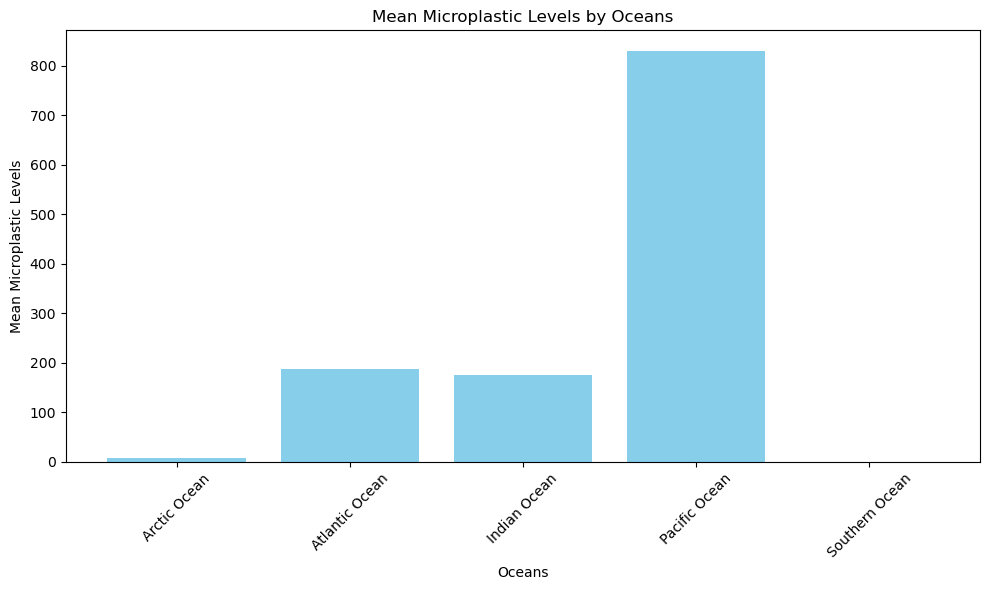

In [11]:
grouped_data = plastic.groupby('Oceans')['Measurement'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(grouped_data['Oceans'], grouped_data['Measurement'], color='skyblue')
plt.xlabel('Oceans')
plt.ylabel('Mean Microplastic Levels')
plt.title('Mean Microplastic Levels by Oceans')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.show()

In [16]:
data_inranges = plastic[plastic['Density Class'].isin(ranges)]
count_values = data_inranges['Density Class'].value_counts()
print(count_values)

Density Class
Medium       7681
Very Low     4887
Low          2030
High         1269
Very High     582
Name: count, dtype: int64


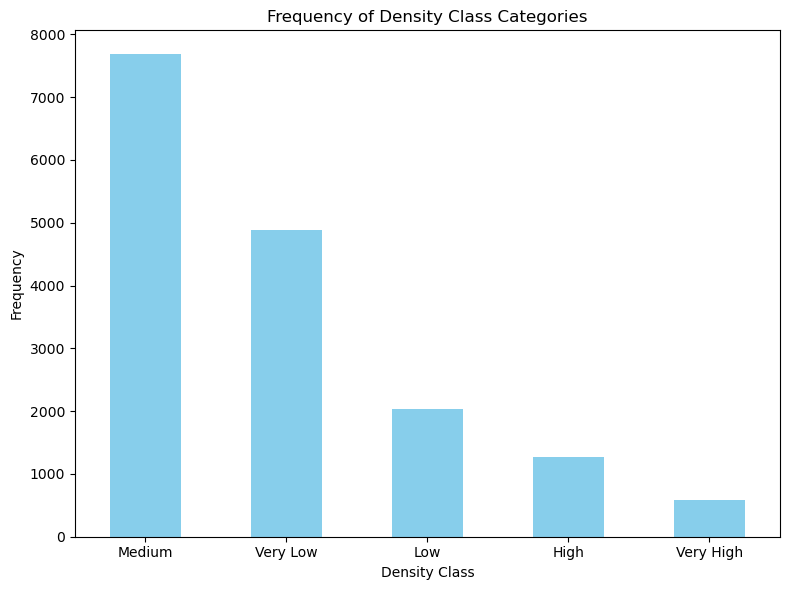

In [17]:
plt.figure(figsize=(8, 6))
count_values.plot(kind='bar', color='skyblue')
plt.xlabel('Density Class')
plt.ylabel('Frequency')
plt.title('Frequency of Density Class Categories')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
gdf.dropna(subset=['Measurement'], inplace=True)

In [20]:
def fill_nan_with_mean(gdf): #Data preprocessing
    coords = gdf[['Longitude', 'Latitude']].values
    measurements = gdf['Measurement'].values

    interpolator = NearestNDInterpolator(coords, measurements)

    nan_indices = gdf['Measurement'].isna()

    gdf.loc[nan_indices, 'Measurement'] = interpolator(gdf[['Longitude', 'Latitude']][nan_indices])
    
    return gdf

In [21]:
gdf = fill_nan_with_mean(gdf)

In [22]:
map_center = [gdf.geometry.y.mean(), gdf.geometry.x.mean()]

map = folium.Map(location=map_center, zoom_start=4)

folium.plugins.Fullscreen(
    position="topright",
    title="Expand me",
    title_cancel="Exit me",
    force_separate_button=True,
).add_to(map)

MousePosition().add_to(map)

map = folium.Map(location=map_center, zoom_start=4)

MiniMap(tile_layer="Cartodb dark_matter", zoom_level_offset=-10).add_to(map)

data = gdf.drop(columns=['geometry'])

In [24]:
heat_data = data[['Latitude', 'Longitude', 'Measurement']].values.tolist()
HeatMap(heat_data, radius=10, blur=5).add_to(map)
map.save("map.html")
features = gdf[['Longitude', 'Latitude']]
print(features)

       Longitude  Latitude
0      -60.29000  45.28000
1      -70.65000  40.93000
2      -70.65000  40.93000
3      -69.77000  40.30000
4      -67.15000  39.88000
...          ...       ...
22261   -8.94286  38.48294
22262   -8.99428  38.46124
22263   -9.04146  38.44652
22264   -9.09325  38.43987
22265   -9.14605  38.42905

[16449 rows x 2 columns]


In [25]:
kmeans = KMeans(
    init="random",
    n_clusters=7,
    n_init=1000,
    max_iter=30000,
    random_state=42
)

kmeans.fit(features)
labels = kmeans.labels_
gdf['cluster'] = labels
_clusters = gdf.groupby('cluster')['Measurement'].count()
print(_clusters)

cluster
0    1053
1     402
2    7289
3    2499
4    3746
5     557
6     903
Name: Measurement, dtype: int64


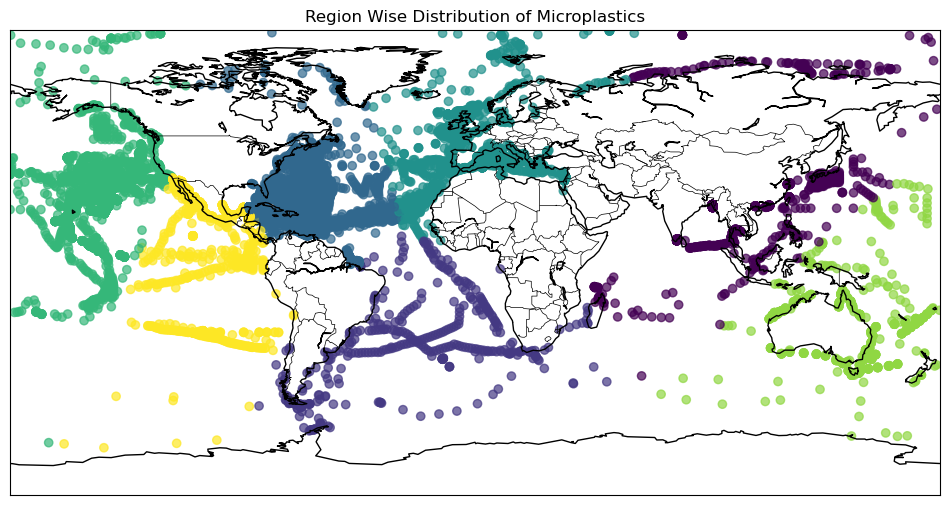

In [26]:
plt.figure(figsize=(12, 8))

m = Basemap(projection='cyl')


m.drawcoastlines()
m.drawcountries()

x, y = m(gdf['Longitude'].values, gdf['Latitude'].values)

m.scatter(x, y, c=gdf['cluster'], cmap='viridis', alpha=0.7)

plt.title('Region Wise Distribution of Microplastics')

plt.show()


## Dataset 2: Coral Bleaching

In [27]:
pip install dash

Note: you may need to restart the kernel to use updated packages.


In [4]:
import plotly.express as px
import dash
from dash import dcc, html, Input, Output
from folium.plugins import HeatMap
import numpy as np
import branca

In [3]:
df = pd.read_csv('./data/global_bleaching_environmental.csv', low_memory=False)
df['Turbidity'] = pd.to_numeric(df['Turbidity'], errors='coerce')
df.dropna(subset=['Turbidity'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])  


mean_turbidity_df = df.groupby(['Ocean_Name', df['Date'].dt.year])['Turbidity'].mean().reset_index()

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='geo-dropdown',
        options=[{'label': ocean, 'value': ocean} for ocean in mean_turbidity_df['Ocean_Name'].unique()],
        value=mean_turbidity_df['Ocean_Name'].unique()[0],  
        clearable=False,
    ),
    dcc.Graph(id='turbidity-graph')
])

@app.callback(
    Output(component_id='turbidity-graph', component_property='figure'),
    [Input(component_id='geo-dropdown', component_property='value')]
)
def update_graph(selected_ocean):
    filtered_df = mean_turbidity_df[mean_turbidity_df['Ocean_Name'] == selected_ocean]  # Use selected_ocean variable
    fig = px.bar(filtered_df, x='Date', y='Turbidity', title=f"Mean Turbidity vs. Year for {selected_ocean} Ocean")
    return fig


if __name__ == '__main__':
    app.run_server(debug=True,port=8056)

In [10]:
df = pd.read_csv('./data/global_bleaching_environmental.csv')
df = df.dropna(subset=['Latitude_Degrees', 'Longitude_Degrees', 'Percent_Bleaching'])

C:\Users\ghana\AppData\Local\Temp\ipykernel_38328\2084385750.py:1: DtypeWarning:

Columns (13,15,24) have mixed types. Specify dtype option on import or set low_memory=False.



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Site_ID                                41361 non-null  int64  
 1   Sample_ID                              41361 non-null  int64  
 2   Data_Source                            41361 non-null  object 
 3   Latitude_Degrees                       41361 non-null  float64
 4   Longitude_Degrees                      41361 non-null  float64
 5   Ocean_Name                             41361 non-null  object 
 6   Reef_ID                                41361 non-null  object 
 7   Realm_Name                             41361 non-null  object 
 8   Ecoregion_Name                         41361 non-null  object 
 9   Country_Name                           41361 non-null  object 
 10  State_Island_Province_Name             41361 non-null  object 
 11  Ci

In [12]:
df['Percent_Bleaching'] = pd.to_numeric(df['Percent_Bleaching'], errors='coerce')

df = df.dropna(subset=['Latitude_Degrees', 'Longitude_Degrees', 'Percent_Bleaching'])

m = folium.Map(location=[0, 0], zoom_start=2)

for index, row in df.iterrows():
    folium.CircleMarker(location=[row['Latitude_Degrees'], row['Longitude_Degrees']],
                        radius=10,
                        color='black',
                        fill=True,
                        fill_color='blue' if row['Percent_Bleaching'] < 0.4 else 'green' if row['Percent_Bleaching'] < 0.65 else 'red',
                        fill_opacity=0.7,
                        popup='Percent Bleaching: {:.2f}'.format(row['Percent_Bleaching'])
                        ).add_to(m)

colormap = branca.colormap.LinearColormap(colors=['blue', 'green', 'red'], vmin=df['Percent_Bleaching'].min(), vmax=df['Percent_Bleaching'].max())
colormap.caption = 'Percent Bleaching'
m.add_child(colormap)

m.add_child(folium.map.LayerControl(position='bottomright'))

m.save('coral_bleaching_map_with_popup_and_legend.html')

C:\Users\ghana\AppData\Local\Temp\ipykernel_32860\1822842643.py:1: DtypeWarning:

Columns (13,15,24) have mixed types. Specify dtype option on import or set low_memory=False.



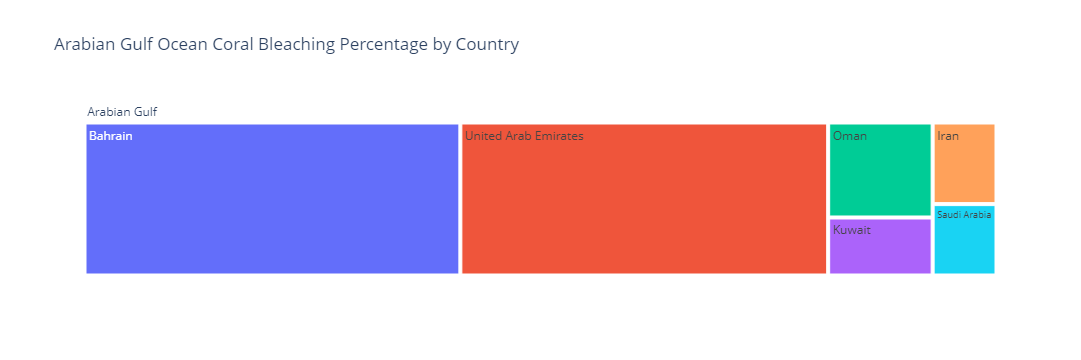

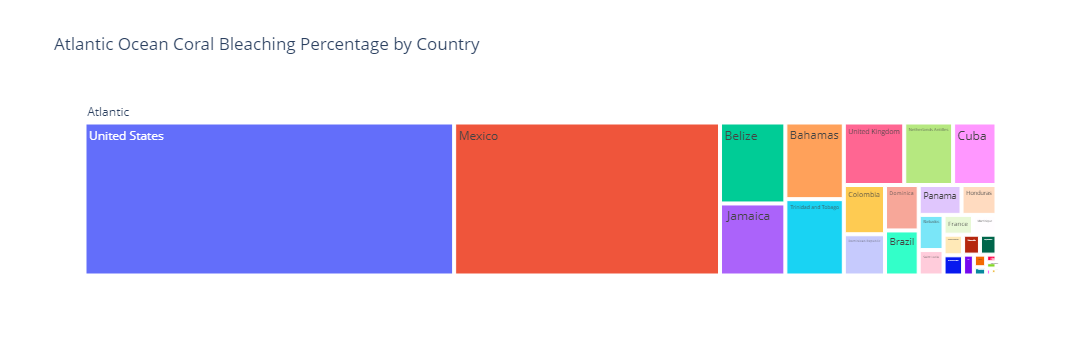

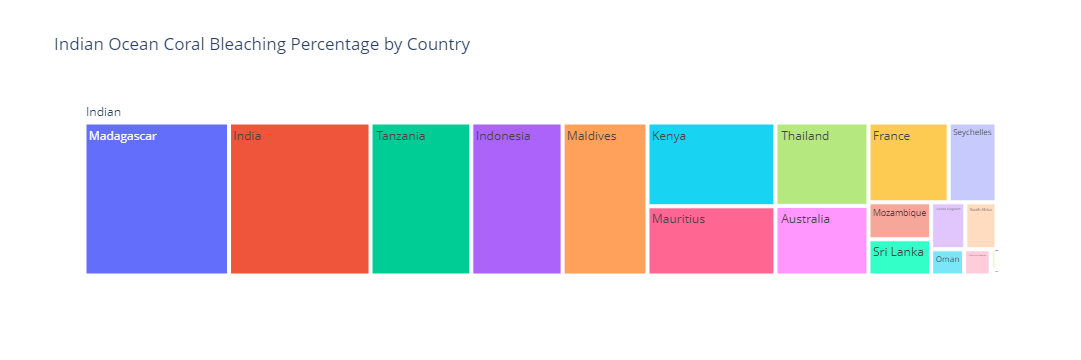

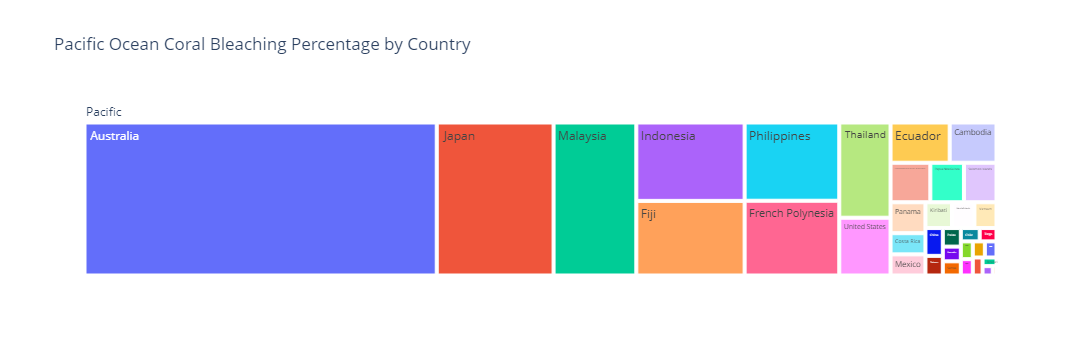

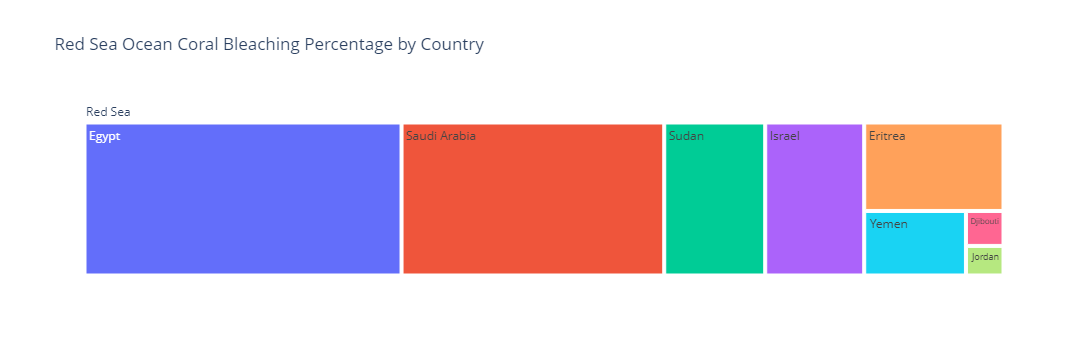

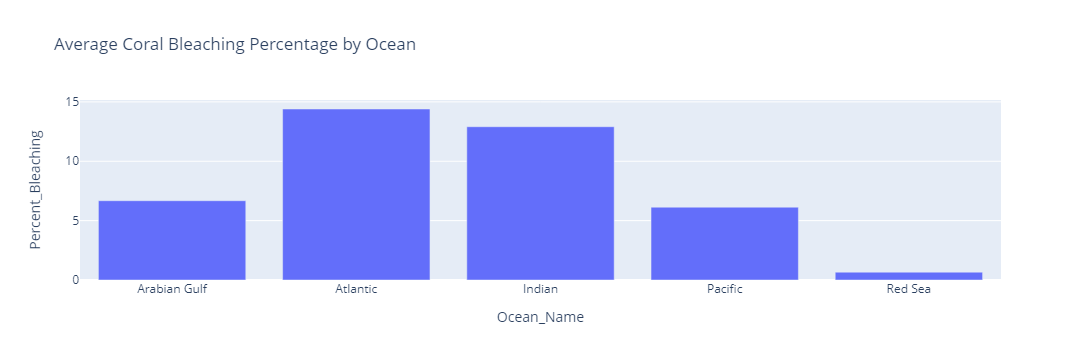

In [35]:
df = pd.read_csv('./data/global_bleaching_environmental.csv')


df['Percent_Bleaching'] = pd.to_numeric(df['Percent_Bleaching'], errors='coerce')


avg_bleaching = df.groupby('Ocean_Name')['Percent_Bleaching'].mean().reset_index()


for ocean in avg_bleaching['Ocean_Name'].unique():
    df_ocean = df[df['Ocean_Name'] == ocean]
    fig = px.treemap(df_ocean, path=['Ocean_Name', 'Country_Name'], values='Percent_Bleaching',
                     title=f'{ocean} Ocean Coral Bleaching Percentage by Country')
    fig.show()


fig_avg = px.bar(avg_bleaching, x='Ocean_Name', y='Percent_Bleaching', 
                  title='Average Coral Bleaching Percentage by Ocean')
fig_avg.show()


## Dataset 3

In [51]:
#preprocessing
# Convert 'Year', 'Month', and 'Day' columns to datetime format
biodiversity_df['Date'] = pd.to_datetime(biodiversity_df[['year', 'month', 'day']])

# Aggregate species count by month
monthly_species_count = biodiversity_df.groupby(pd.Grouper(key='Date', freq='M'))['quantity'].sum().reset_index()


C:\Users\ghana\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



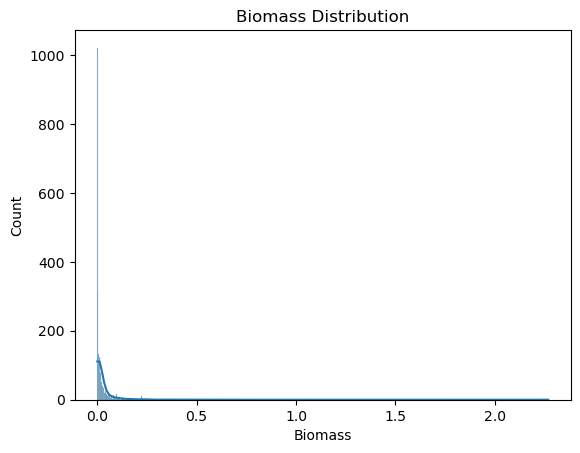

In [56]:
import seaborn as sns

sns.histplot(df['biomass'], kde=True)
plt.xlabel('Biomass')
plt.ylabel('Count')
plt.title('Biomass Distribution')
plt.show()

In [34]:
print(fish_data.columns)


Index(['label\t"year"\t"month"\t"day"\t"region"\t"island"\t"side"\t"id_reef"\t"reef"\t"reef_joined"\t"protection_status"\t"Latitude"\t"Longitude"\t"habitat"\t"transect"\t"area"\t"phylum"\t"taxa1"\t"taxa2"\t"taxa3"\t"family"\t"trophic_group"\t"trophic_level"\t"functional_groups"\t"a_ord"\t"b_pen"\t"species"\t"quantity"\t"size"\t"biomass"'], dtype='object')


  label  year  month  day          region              island      side  \
0   PEC  2019      8   10  Bajo del Norte     Bajos del Norte     Bajos   
1   PEC  2019      8    9       Alacranes  Arrecife Alacranes  Windward   
2   PEC  2019      8   11  Bajo del Norte     Bajos del Norte     Bajos   
3   PEC  2019      8    9       Alacranes  Arrecife Alacranes   Leeward   
4   PEC  2019      8    8       Alacranes  Arrecife Alacranes   Leeward   

   id_reef               reef  reef_joined  ...         family  \
0       11  Bajos del norte 2            7  ...  Pomacentridae   
1        9        Tata y Rafa            3  ...     Balistidae   
2       15              Final           10  ...     Balistidae   
3        7        Alacranes 7            4  ...       Scaridae   
4        4           Sardinas            4  ...       Scaridae   

    trophic_group  trophic_level   functional_groups   a_ord  b_pen  \
0  Zooplanktivore           3.82        planktivores  0.0170  3.120   
1       Ca

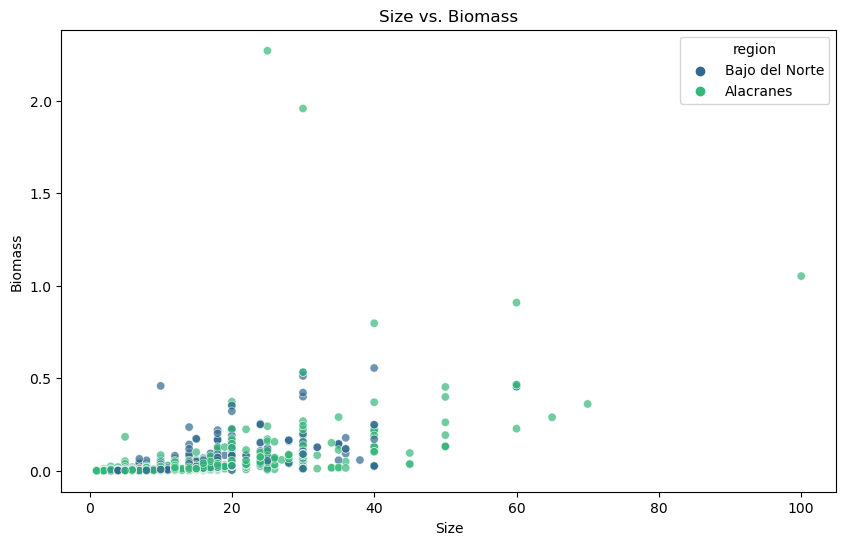

In [6]:

# Load the data with correct delimiter
fish_data = pd.read_csv('./data/fish_data.csv', delimiter='\t')

# Display the first few rows of the dataframe
print(fish_data.head())

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot of size vs. biomass
sns.scatterplot(x='size', y='biomass', data=fish_data, hue='region', palette='viridis', alpha=0.7)
plt.title('Size vs. Biomass')
plt.xlabel('Size')
plt.ylabel('Biomass')

plt.show()


C:\Users\ghana\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


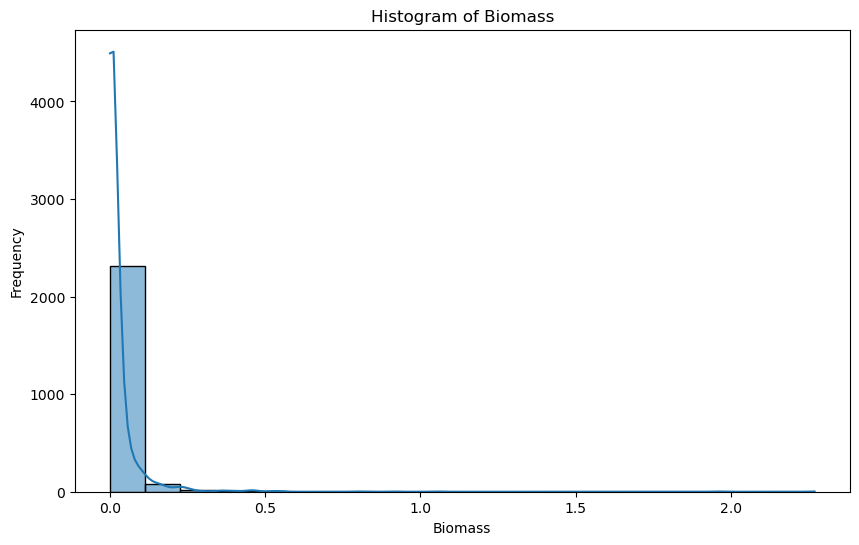

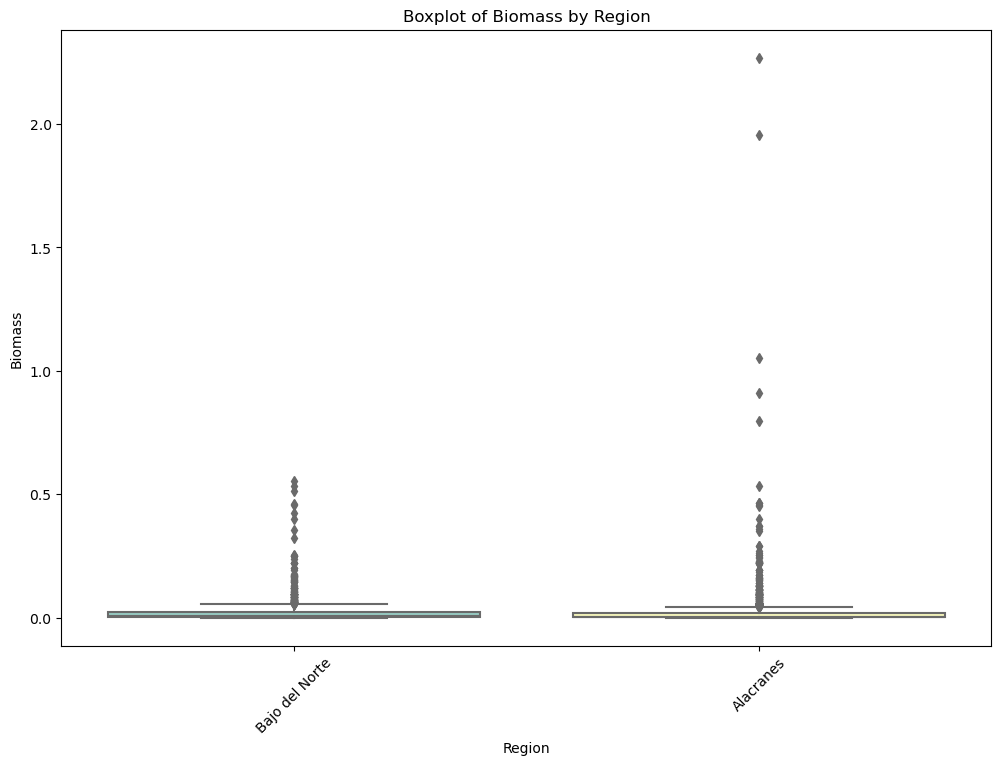

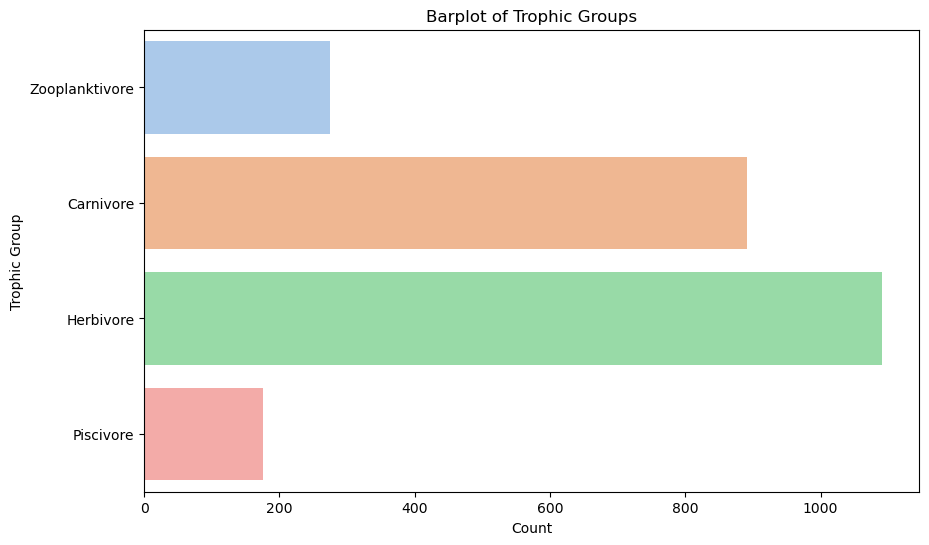

In [7]:
# Plotting histogram of Biomass
plt.figure(figsize=(10, 6))
sns.histplot(fish_data['biomass'], bins=20, kde=True)
plt.title('Histogram of Biomass')
plt.xlabel('Biomass')
plt.ylabel('Frequency')
plt.show()

# Boxplot of Biomass by Region
plt.figure(figsize=(12, 8))
sns.boxplot(x='region', y='biomass', data=fish_data, palette='Set3')
plt.title('Boxplot of Biomass by Region')
plt.xlabel('Region')
plt.ylabel('Biomass')
plt.xticks(rotation=45)
plt.show()

# Barplot of Trophic Groups
plt.figure(figsize=(10, 6))
sns.countplot(y='trophic_group', data=fish_data, palette='pastel')
plt.title('Barplot of Trophic Groups')
plt.xlabel('Count')
plt.ylabel('Trophic Group')
plt.show()


C:\Users\ghana\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ghana\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ghana\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


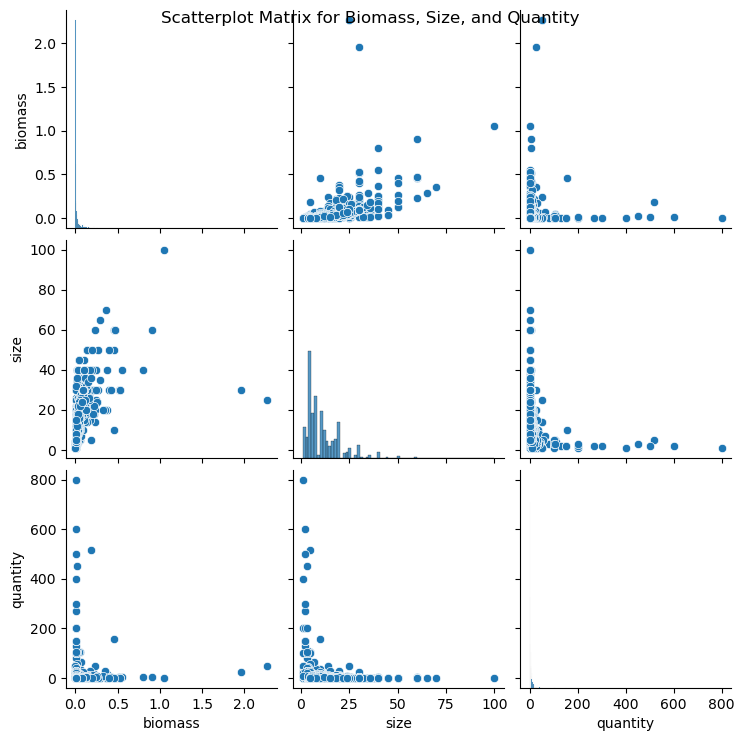

In [8]:
# Scatterplot Matrix for selected numeric variables
numeric_vars = ['biomass', 'size', 'quantity']
sns.pairplot(fish_data[numeric_vars])
plt.suptitle('Scatterplot Matrix for Biomass, Size, and Quantity')
plt.show()

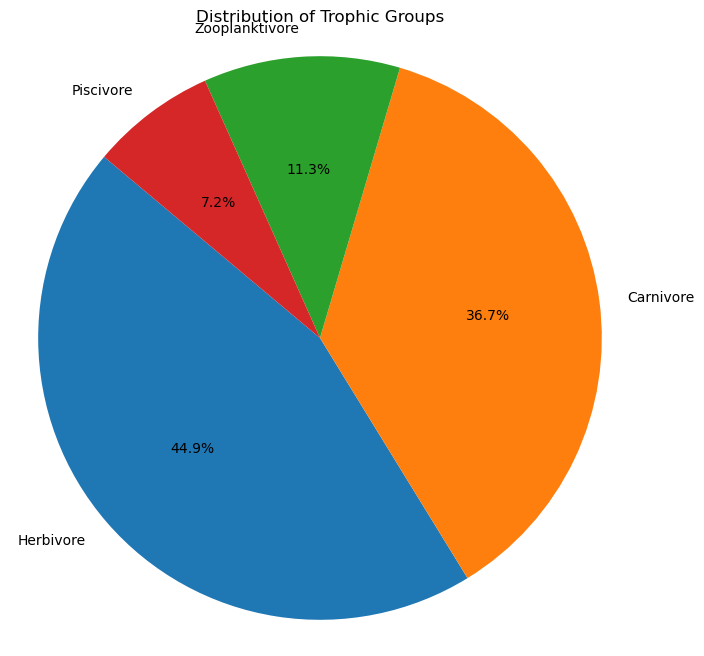

In [9]:
# Calculate the counts of each trophic group
trophic_group_counts = fish_data['trophic_group'].value_counts()

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(trophic_group_counts, labels=trophic_group_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Trophic Groups')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


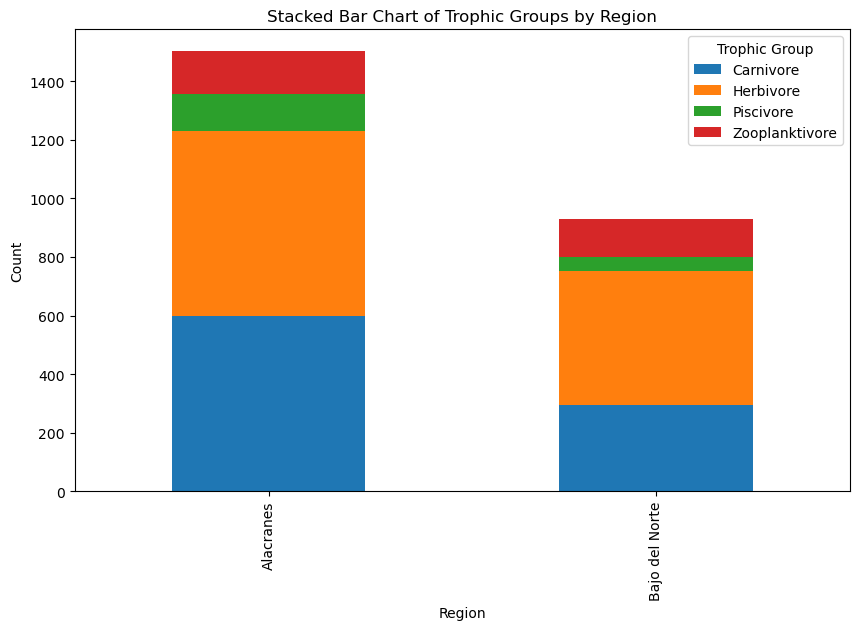

In [11]:
stacked_data = fish_data.groupby(['region', 'trophic_group']).size().unstack()
stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Stacked Bar Chart of Trophic Groups by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Trophic Group')
plt.show()


C:\Users\ghana\AppData\Local\Temp\ipykernel_7208\3557120384.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='size', y='biomass', data=fish_data, hue='trophic_group', ci=None)
C:\Users\ghana\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ghana\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


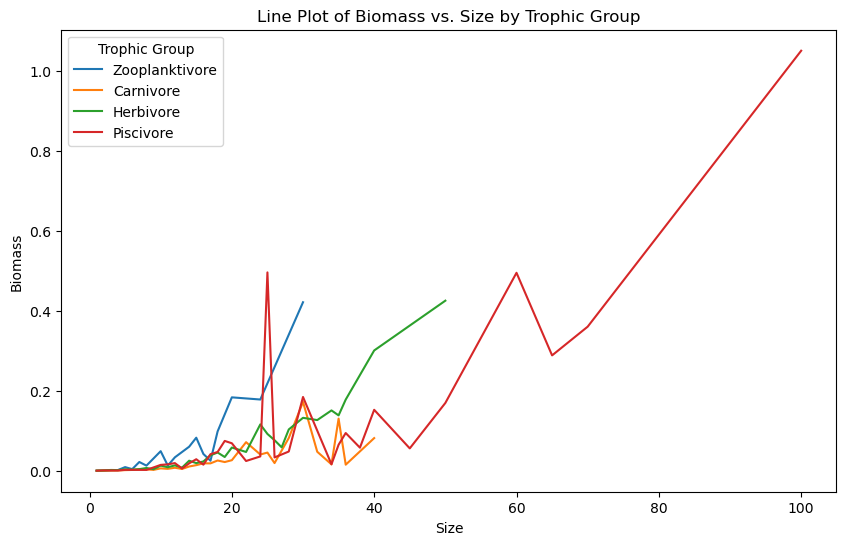

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='size', y='biomass', data=fish_data, hue='trophic_group', ci=None)
plt.title('Line Plot of Biomass vs. Size by Trophic Group')
plt.xlabel('Size')
plt.ylabel('Biomass')
plt.legend(title='Trophic Group')
plt.show()

C:\Users\ghana\AppData\Local\Temp\ipykernel_7208\1652017379.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='size', y='biomass', data=fish_data, hue='trophic_group', ci=None, estimator=np.mean)
C:\Users\ghana\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ghana\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


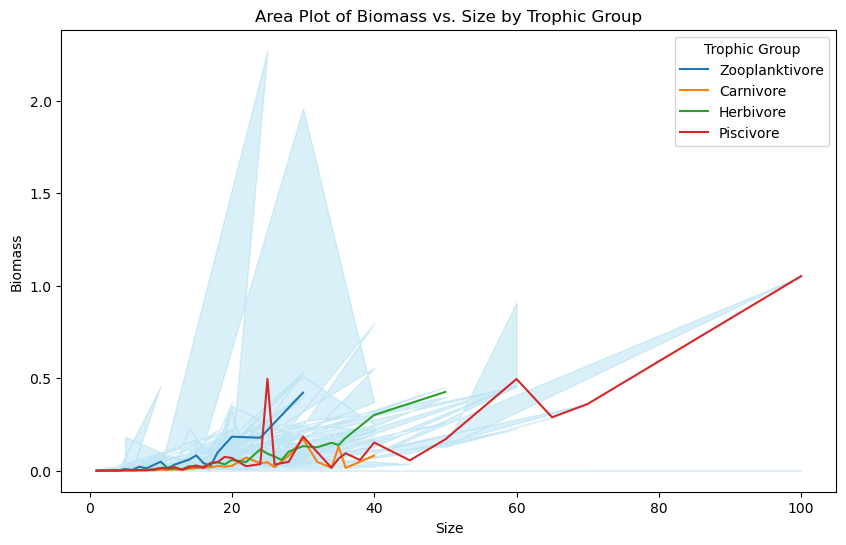

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='size', y='biomass', data=fish_data, hue='trophic_group', ci=None, estimator=np.mean)
plt.fill_between(fish_data['size'], fish_data['biomass'], color="skyblue", alpha=0.3)
plt.title('Area Plot of Biomass vs. Size by Trophic Group')
plt.xlabel('Size')
plt.ylabel('Biomass')
plt.legend(title='Trophic Group')
plt.show()
